# Group Final Report

### Christin Wang, Rongze Wang

## I. Introduction

## II. Methods and Results

### A. Exploratory Data Analysis

In [52]:
library(MASS)
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(GGally)
library(AER)
library(modelr)
library(gridExtra)
library(grid)
library(rsample)
library(yardstick)
library(gridExtra)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(cowplot)
library(caret)
library(ISLR)
library(pROC)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




### 1. Data Preparation

- Read the csv file of `processed.cleveland.data`.
- Rename the column names of the dataset.
- Change the diagnosis presence values (1,2,3,4) all into 1.
- Mutate all catagorical variables into factors for coding convinience.
- Drop any NA values.

In [53]:
heart_data <- read_csv("https://raw.githubusercontent.com/Speculatorrr/STAT301/main/processed.cleveland.data?token=GHSAT0AAAAAACVKAVDCISXAPJBRTBVAWBUQZVEDPNQ", 
                        col_names = FALSE)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol",
                            "fbs", "restecg", "thalach", "exang", "oldpeak",
                            "slope", "ca", "thal", "num")

categorical_vars <- c("sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal")

heart_data <- heart_data %>%
    mutate(num = if_else(num > 0, 1, 0)) %>%
    mutate(across(all_of(categorical_vars), as.factor),
    num = as.factor(num)) %>%
    drop_na()

head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


Table 1: Tidy Cleveland heart disease data

### 2. Plotting relevant raw data

**[Graph1] Bar Chart of Categorical Variables Labeled by Heart Disease Diagnosis Results**

- This graph compares the frequencies of diagnosis results within 8 different categorical variables, and identifies which categorical variables are more strongly associated with heart disease. Making us better to understand the impact of each categorical variable on heart disease.

    In this case, we see that `cp`, `restecg`, `exang`, `slope`, `ca` and `thal` have a relatively stronger association with the presence of heart disease.

- I've also included a barchart for `num` counting the presence of heart disease to make sure that the classes are not imbalanced. Fortunately, they are balanced.

In [54]:
options(repr.plot.width = 15, repr.plot.height = 15) 

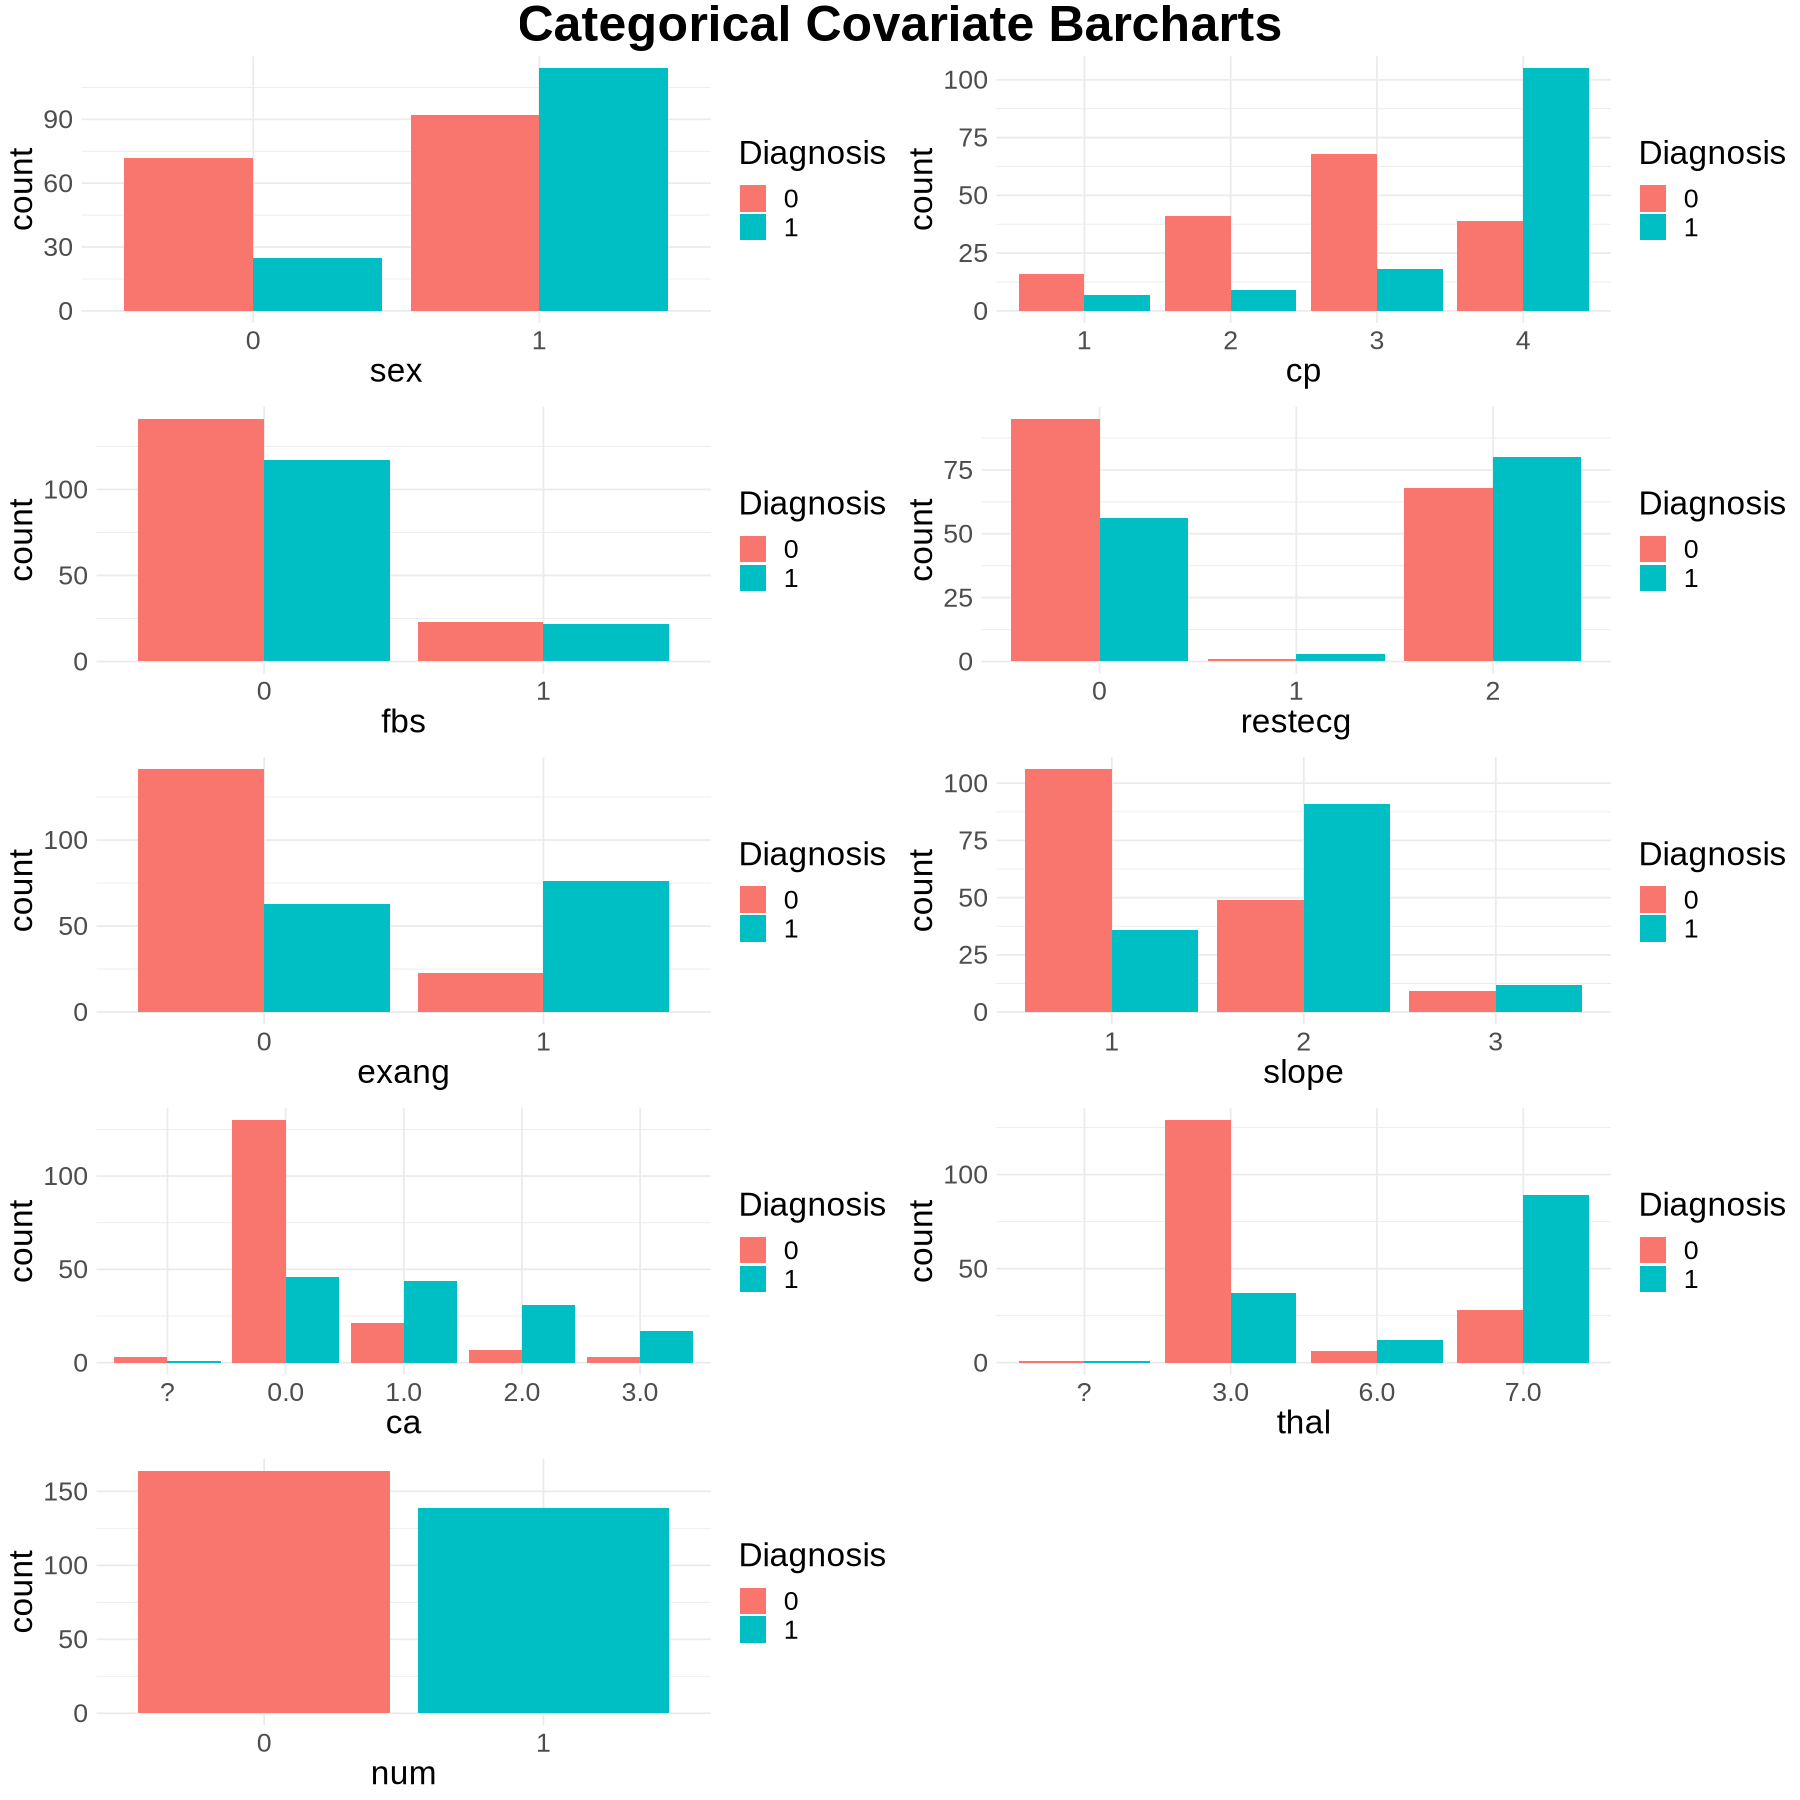

In [55]:
draw_bar_chart <- function(data, categorical_vars, num) {
  ggplot(data, aes_string(x = categorical_vars, fill = num)) +
    geom_bar(position = "dodge") +
    theme_minimal() +
    theme(text = element_text(size = 20)) +
    labs(x = categorical_vars, fill = "Diagnosis")
}

sex_bar <- draw_bar_chart(heart_data, "sex", "num")
cp_bar <- draw_bar_chart(heart_data, "cp", "num")
fbs_bar <- draw_bar_chart(heart_data, "fbs", "num")
restecg_bar <- draw_bar_chart(heart_data, "restecg", "num")
exang_bar <- draw_bar_chart(heart_data, "exang", "num")
slope_bar <- draw_bar_chart(heart_data, "slope", "num")
ca_bar <- draw_bar_chart(heart_data, "ca", "num")
thal_bar <- draw_bar_chart(heart_data, "thal", "num")
num_bar <- draw_bar_chart(heart_data, "num", "num")

grid.arrange(
  sex_bar, cp_bar, fbs_bar, restecg_bar,
  exang_bar, slope_bar, ca_bar, thal_bar, num_bar,
  ncol = 2,
  top = textGrob("Categorical Covariate Barcharts", gp = gpar(fontsize = 30, fontface = "bold"))
)

**[Graph3] Correlation Matrix Heatmap of Numerical Variables**

- Similar but more accurate than `ggpairs`, by visualizing the pairwise correlations between numerical variables, this helps to identify the degree of association between variables and detect multicollinearity, which can insure the correctness of our prediction.

    Unlike the pairs (`chol`&`age`, `chol`&`thalach`, `age`&`thalach)` that I sense to have the strongest correlation from the `ggpairs` plot above. Within this heatmap, `trestbps`&`age`, `age`&`thalach`, `oldpeak`&`thalach` are shown to have the strongest correlation. So, we might want to put multicollinearity into concern for these variables, probably dropping one afterwards.
    

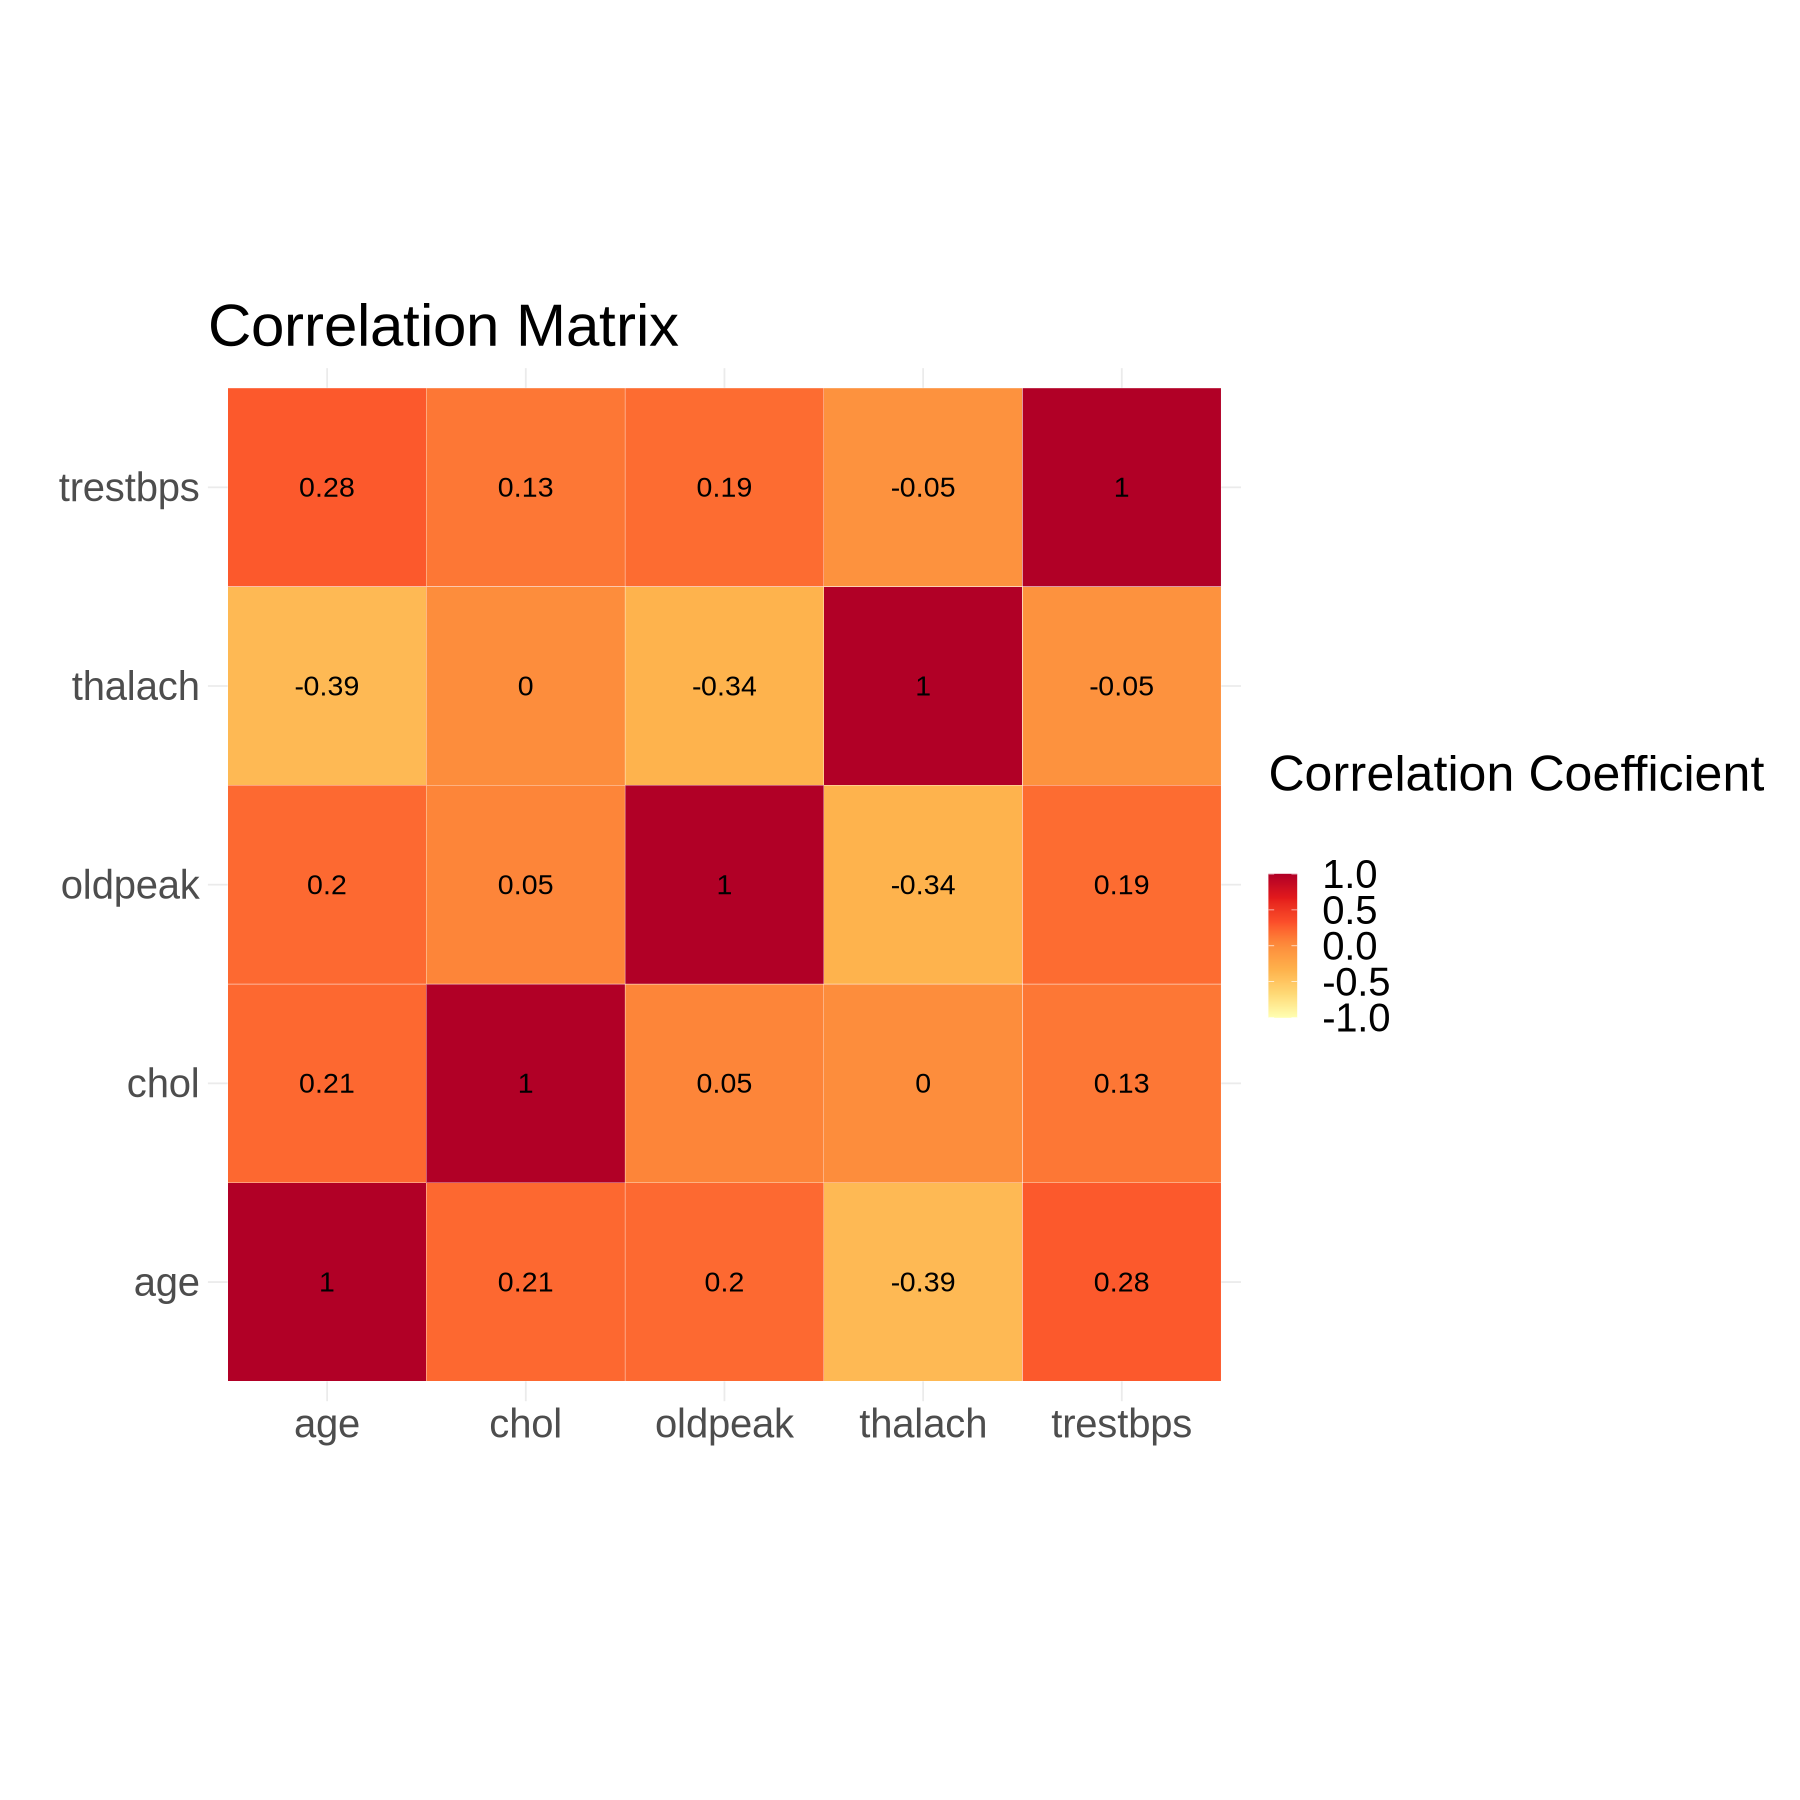

In [56]:
corr_matrix <- heart_data %>%
            select(-categorical_vars, -num) %>%
            cor() %>%
            as_tibble(rownames = 'var1') %>%
            pivot_longer(-var1, names_to = "var2", values_to = "corr")

plot_corr_matrix <- corr_matrix %>%
   ggplot(aes(var1, var2)) +
   geom_tile(aes(fill = corr), color = "white") +
   scale_fill_distiller("Correlation Coefficient \n",
       palette =  "YlOrRd",
       direction = 1, 
       limits = c(-1, 1)
     ) +
     labs(x = "", y = "") +
     theme_minimal() +
     theme(text = element_text(size = 30)) +
     coord_fixed() +
   geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6) +
   ggtitle("Correlation Matrix")

plot_corr_matrix

**[Graph4] Boxplots Comparing Heart Disease Diagnosis between Numerical Variables**

- By illustrating the distribution of numerical variables grouped by heart disease diagnosis, we can easily see the differences in the distribution of values, including the presence of outliers, mean, median and variability. Comparing these can help us identify which variables are more influential in predicting heart disease.

    We will compare the median since the mean may be affected by outliers.
    In this case, we see that `age`, `oldpeak` and `thalach` has a relatively big differences between diagnosis results. Thus, would be more useful in the prediction model.


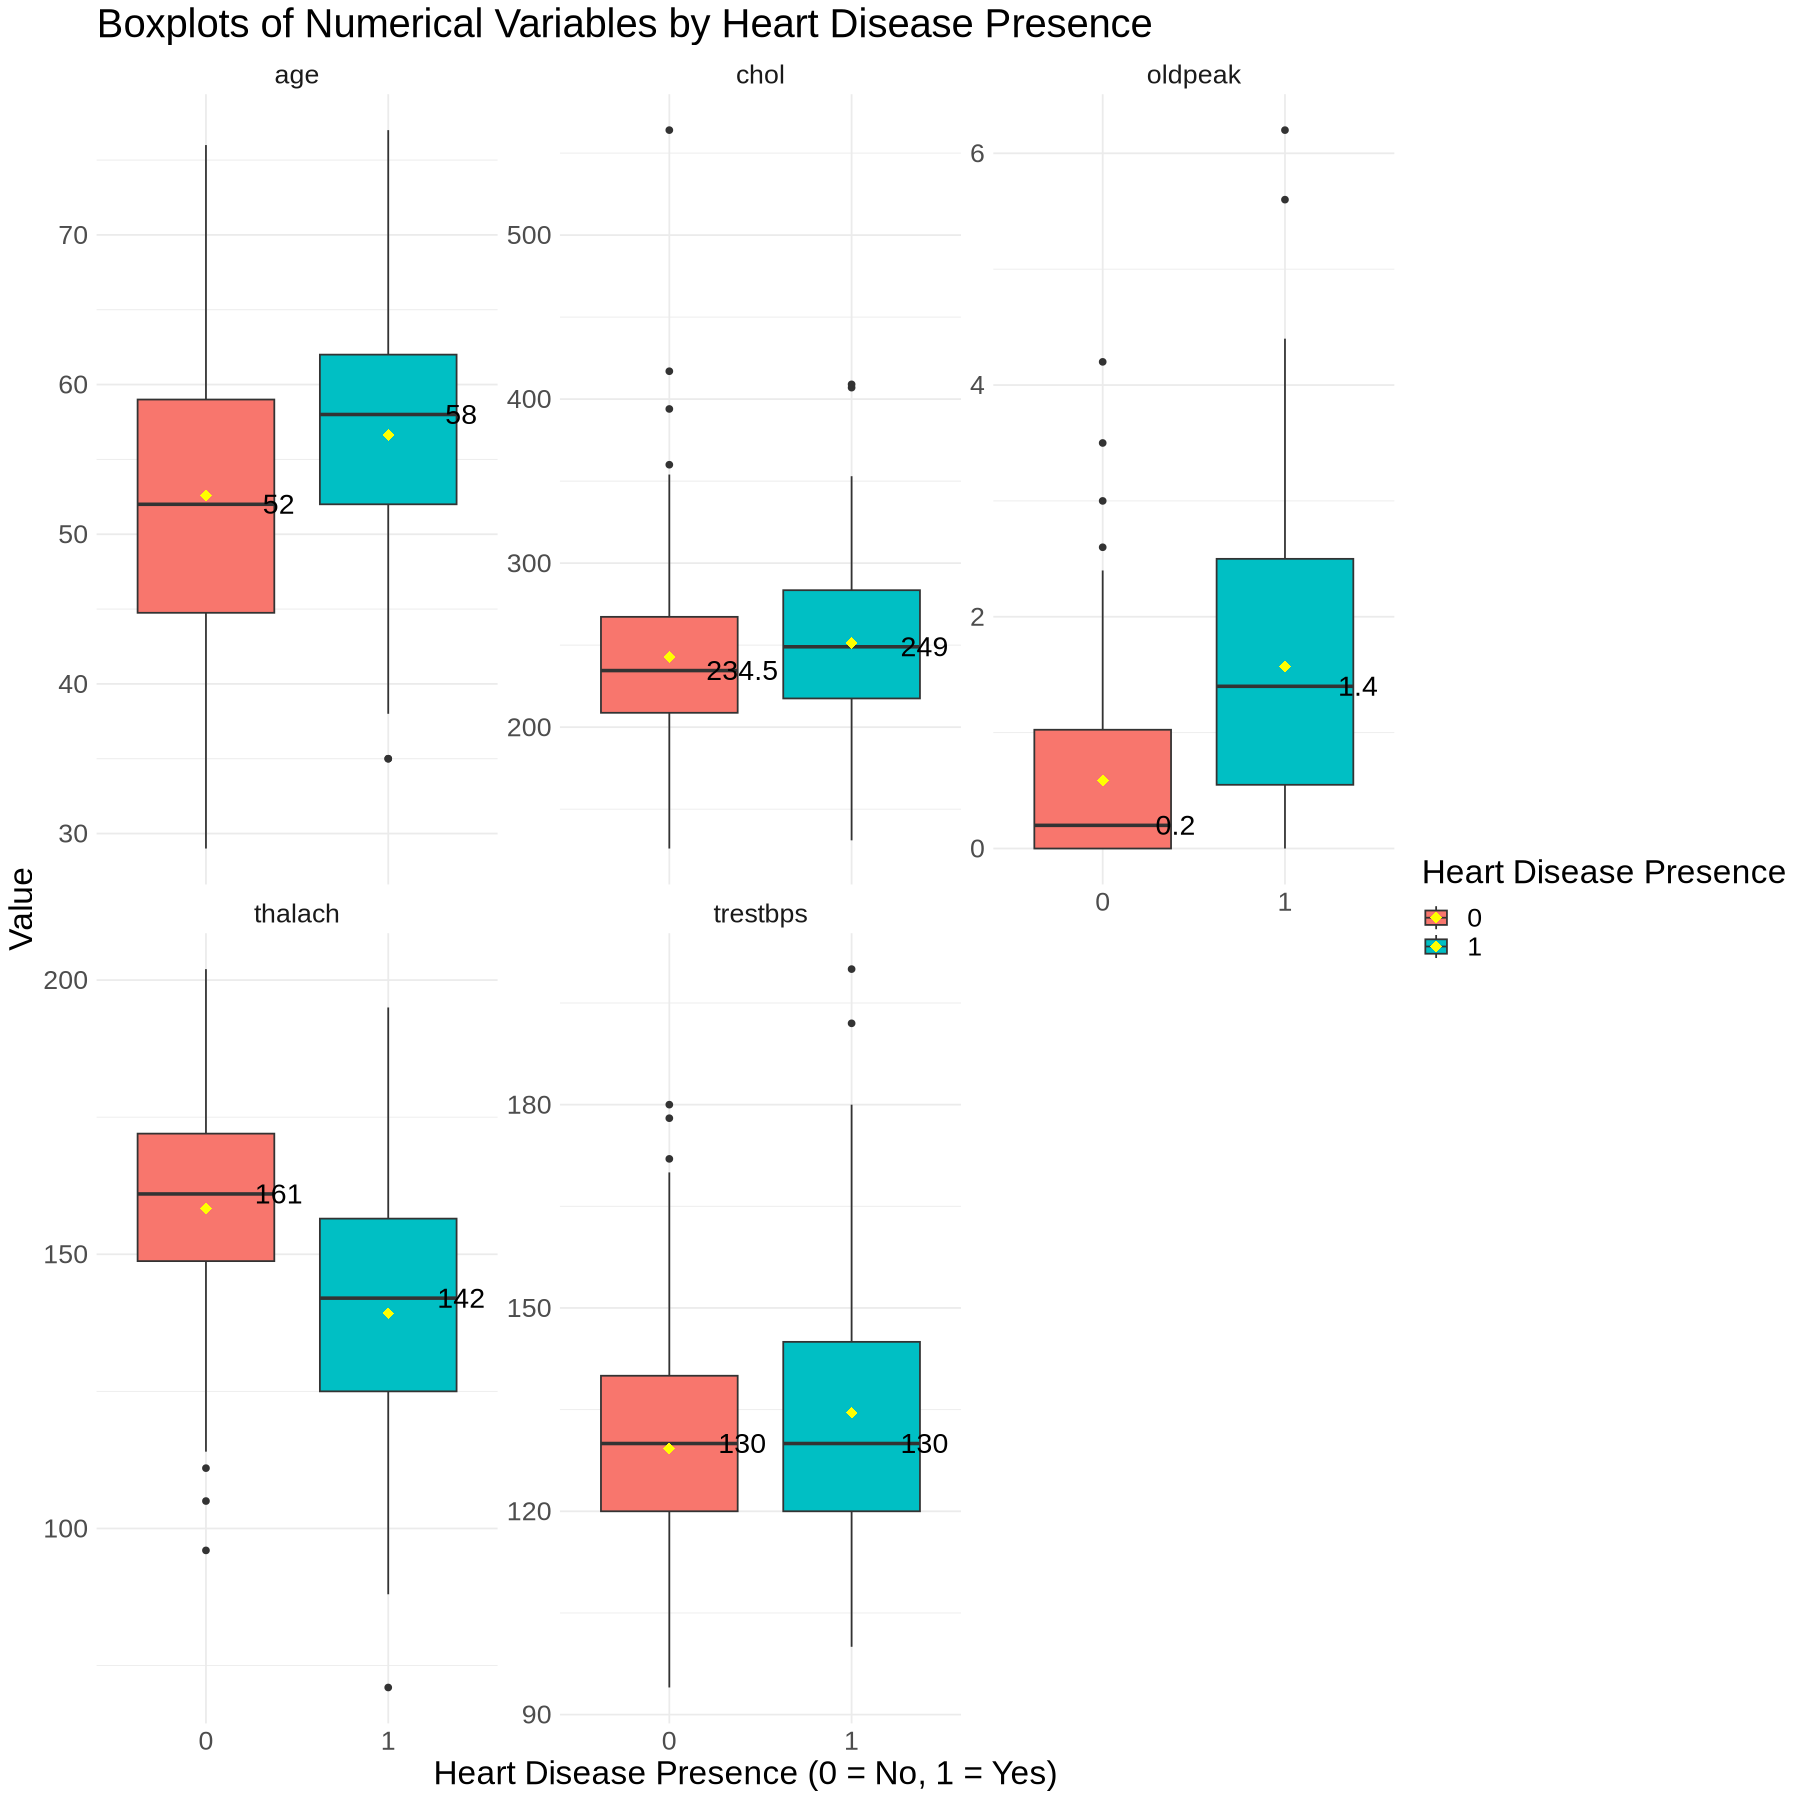

In [57]:
heart_long <- heart_data %>%
  select(- categorical_vars) %>%
  pivot_longer(cols = -num , names_to = "variable", values_to = "value")

heart_boxplot <- heart_long %>%
  ggplot(aes(x = as.factor(num), y = value, fill = as.factor(num))) +
  geom_boxplot() +
  stat_summary(aes(label = round(..y.., 2)),
               fun = median,
               geom = "text",
               position = position_nudge(x = 0.4, y = 0),
               size = 6) +
  facet_wrap(~ variable, scales = "free_y") +
  stat_summary(aes(as.factor(num), value, fill = as.factor(num)),
               fun = mean,
               colour = "yellow",
               geom = "point",
               shape = 18,
               size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 20)) +
  labs(title = "Boxplots of Numerical Variables by Heart Disease Presence", 
       x = "Heart Disease Presence (0 = No, 1 = Yes)", y = "Value") +
  scale_fill_discrete(name = "Heart Disease Presence")
heart_boxplot



**Visualization Conclusion**

After looking into the 4 graphs, we get a comprehensive overview of the data. At this point, I assume that `age`, `oldpeak`, `thalach`, `cp`, `restecg`, `exang`, `slope`, `ca` and `thal`, these 9 covariates are more relevant to heart disease diagnosis. Additionally, there may be multicollinearity amongst the variables `trestbps`,`age`, `thalach` and `oldpeak`.

### B. Methods

#### 1. Split data into train & test

In [58]:
heart_split <- 
    heart_data %>%
    initial_split(prop = 0.7, strata = num)
    
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

#### 2. Fit the full Logistic Regression model by the training set

In [59]:
heart_full_log <- glm(num ~ .,
                data = heart_train,
                family = binomial)

heart_full_tidy <- heart_full_log %>%
    tidy() %>%
    mutate(estimate = exp(estimate)) %>%
    mutate_if(is.numeric, round, 2)

heart_full_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.07,4.40,-0.60,0.55
age,0.95,0.03,-1.57,0.12
sex1,4.85,0.66,2.39,0.02
cp2,3.21,0.92,1.27,0.20
cp3,1.01,0.84,0.01,0.99
cp4,5.00,0.80,2.01,0.04
trestbps,1.02,0.01,1.26,0.21
chol,1.00,0.01,0.69,0.49
fbs1,0.51,0.70,-0.96,0.34


#### 3. Check for Collinarity by using `vif`

In [60]:
vif_value <- vif(heart_full_log) 

vif_df <- data.frame(
  Variable = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"),
  GVIF_Adj = c(1.297, 1.357, 1.173, 1.261, 1.184, 1.099, 1.055, 1.220, 1.099, 1.360, 1.219, 1.145, 1.102)
  ) %>%
  arrange(desc(GVIF_Adj))
  
vif_df

Variable,GVIF_Adj
<chr>,<dbl>
oldpeak,1.360
sex,1.357
age,1.297
trestbps,1.261
thalach,1.220
slope,1.219
chol,1.184
cp,1.173
ca,1.145


GVIF_Adj is the GVIF adjusted for the degrees of freedom. This adjustment helps standardize the GVIF values across variables with different numbers of levels, which is particularly useful for categorical variables.

No variables have a GVIF_Adj (or any other VIF measure) greater than 5, it generally suggests that multicollinearity is not a severe issue in our model.

In [61]:
# Install and load necessary packages

library(leaps)

library(bestglm)

# Prepare your data
# Assuming your data frame is named heart_data and 'num' is the dependent variable
heart_data <- heart_data %>% mutate(num = as.factor(num))

# Use bestglm to fit models and select based on Mallow's Cp
# Note: bestglm is designed for linear models but can be adapted for logistic regression
heart_best_model <- bestglm(heart_data, 
                            IC = "Cp", 
                            family = binomial)

# Summarize the selected model
summary(heart_best_model$BestModel)

# Tidy the results of the selected model
selected_model_tidy <- heart_best_model$BestModel %>%
    tidy() %>%
    mutate(estimate = exp(estimate)) %>%
    mutate_if(is.numeric, round, 2)

print(selected_model_tidy)


ERROR: Error in library(bestglm): there is no package called ‘bestglm’


In [ ]:
heart_test <- 
    heart_test %>%
    add_predictions(heart_full_log, var = "pred") %>%
    mutate(pred = as.factor(if_else(pred>0.5, 1, 0) ) )

In [ ]:
head(heart_test)

In [ ]:

test_metrics <- 
    heart_test %>%
    metrics(truth = num, estimate = pred)


#### 4. Make a forward selection. Out of the 13 models, select the best one in terms of its goodness of fit (smallest AIC𝑝
).

In [62]:
null_model <- glm(num ~ 1, data = heart_data, family = binomial)

forward_sel <- stepAIC(null_model, direction = "forward", 
                         scope = list(lower = null_model, upper = heart_full_log))

summary(forward_sel)

Start:  AIC=419.98
num ~ 1

           Df Deviance    AIC
+ thal      3   330.60 338.60
+ cp        3   331.86 339.86
+ ca        4   341.72 351.72
+ oldpeak   1   357.20 361.20
+ exang     1   359.54 363.54
+ thalach   1   360.90 364.90
+ slope     2   370.76 376.76
+ sex       1   393.93 397.93
+ age       1   402.54 406.54
+ restecg   2   407.84 413.84
+ trestbps  1   411.03 415.03
+ chol      1   415.78 419.78
<none>          417.98 419.98
+ fbs       1   417.79 421.79

Step:  AIC=338.6
num ~ thal

           Df Deviance    AIC
+ ca        4   274.50 290.50
+ cp        3   279.14 293.14
+ thalach   1   297.00 307.00
+ oldpeak   1   300.05 310.05
+ exang     1   300.20 310.20
+ slope     2   307.31 319.31
+ age       1   320.14 330.14
+ restecg   2   318.53 330.53
+ sex       1   327.67 337.67
+ chol      1   327.79 337.79
+ trestbps  1   327.83 337.83
<none>          330.60 338.60
+ fbs       1   330.51 340.51

Step:  AIC=290.5
num ~ thal + ca

           Df Deviance    AIC
+ cp   


Call:
glm(formula = num ~ thal + ca + cp + oldpeak + slope + sex + 
    trestbps + exang, family = binomial, data = heart_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9358  -0.4831  -0.1229   0.3463   2.9987  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -7.78439    4.46368  -1.744  0.08117 .  
thal3.0     -2.24995    3.70784  -0.607  0.54398    
thal6.0     -2.47520    3.77569  -0.656  0.51211    
thal7.0     -0.83940    3.71096  -0.226  0.82105    
ca0.0        1.12685    1.63454   0.689  0.49057    
ca1.0        3.40654    1.69270   2.012  0.04417 *  
ca2.0        4.07792    1.81968   2.241  0.02503 *  
ca3.0        3.34023    1.84440   1.811  0.07014 .  
cp2          1.41765    0.79381   1.786  0.07412 .  
cp3          0.32082    0.68953   0.465  0.64173    
cp4          2.57209    0.69400   3.706  0.00021 ***
oldpeak      0.46158    0.22843   2.021  0.04332 *  
slope2       1.49041    0.46137   3.230  0.00124 ** 


chosen variables: thal + ca + cp + oldpeak + slope + sex + trestbps + exang

## Re-fit a logistic regression model with the selected variables

In [63]:
forward_tidy <- forward_sel %>%
    tidy() %>%
    mutate(estimate = exp(estimate)) %>%
    mutate_if(is.numeric, round, 2)

forward_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.00,4.46,-1.74,0.08
thal3.0,0.11,3.71,-0.61,0.54
thal6.0,0.08,3.78,-0.66,0.51
thal7.0,0.43,3.71,-0.23,0.82
ca0.0,3.09,1.63,0.69,0.49
ca1.0,30.16,1.69,2.01,0.04
ca2.0,59.02,1.82,2.24,0.03
ca3.0,28.23,1.84,1.81,0.07
cp2,4.13,0.79,1.79,0.07


## Model Evaluation

Now, we can test the performance of our new logistic regression model on test set

In [71]:
heart_pred_class <- 
        round(predict(forward_sel,type="response"),0)
head(heart_pred_class, 10)

1  2  3  4  5  6  7  8  9 10 
 0  1  1  0  0  0  1  0  1  1

In [72]:
heart_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(heart_pred_class),
    reference = as.factor(heart_train$num),
    positive = '1'
)
heart_confusion_matrix

ERROR: Error in table(data, reference, dnn = dnn, ...): all arguments must have the same length


## III. Discussion

## IV. References (APA)

- Lloyd-Jones, D. M., Larson, M. G., Beiser, A., & Levy, D. (1999). Lifetime risk of developing coronary heart disease. The Lancet, 353(9147), 89-92. https://doi.org/10.1016/S0140-6736(98)10279-9
